# IMDb Scraping

In [3]:
import pandas as pd
from selenium import webdriver

from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException 
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options

from bs4 import BeautifulSoup
import requests
import time
import re

In [6]:
# ratings container
# rating tags

# title
# year
# critics rating
# metascore
# vote
# director
# genre
# gross worldwide
# motion picture rating (MPAA)

def scrape_imdb():
    MAX_DELAY = 15
    MAX_NUMBER_OF_TITLES = 252

    path = ChromeDriverManager().install() # install latest driver (returns path of the installed driver)

    driver = webdriver.Chrome(executable_path=path)

    titles = []
    years = []
    critics_ratings = []
    metascore_ratings  = []
    votes = []
    directors = []
    genres  = []
    gross_worldwide = []
    mpaa_ratings = []

    x = 1
    while x < MAX_NUMBER_OF_TITLES:
        # ---------- Scraping one IMDB page ---------- #
        # parameters in url begin with ?, are assigned by parameter=value, and are separated by &
        # url = "https://www.imdb.com/search/title/?year=2001&start=" + str(x) + "&title_type=feature"
        url = f"https://www.imdb.com/search/title/?release_date=2000-01-01%2C2021-12-31&groups=top_250&start={x}&ref_=adv_nxt"
        print(url) # printing as a sanity check
        driver.get(url)
        try:
            WebDriverWait(driver, MAX_DELAY).until(EC.presence_of_element_located((By.CLASS_NAME, "pagecontent")))
        except TimeoutException:
            print('Loading exceeds delay time')

        soup = BeautifulSoup(driver.page_source, "html.parser")

        # ---------- find container of rating tags ---------- #
        rating_container = soup.find("div", class_="pagecontent")

        # ---------- find all rating tags ---------- #
        rating_tags = rating_container.findAll("div", class_="lister-item")

        # ---------- for each tag in rating tags ---------- #
        for rating_tag in rating_tags:
            # parse each tag and append data into lists
            # ---------- Scraping one rating cell ---------- #
            title = get_title(rating_tag)

            year_tag = rating_tag.find("span", class_="lister-item-year")
            year_name = year_tag.text.strip()
            year_re = re.search("((.*))", year_name)
            year = year_re.group().replace("(","").replace(")","").replace("I", "")
            year

            critics_rating_tag = rating_tag.find("div", class_="ratings-imdb-rating")
            rating = critics_rating_tag.find("strong").text.strip()

            try:
                metascore_tag = rating_tag.find("div", class_="ratings-metascore")
                metascore = metascore_tag.find("span").text.strip()
            except AttributeError:
                metascore = None

            vote_tag = rating_tag.find("p", class_="sort-num_votes-visible")
            vote = vote_tag.text.split()[1]

            director_tag = rating_tag.find("p", {"class": ''})
            director_name = director_tag.text.strip()            
            directors_re = re.search(("Director:\n(.*)\n|"), director_name)
            director = directors_re.group().replace("Director:", "").strip()
            director

            genre_tag = rating_tag.find("span", class_="genre")
            genre = genre_tag.text.strip()

            # ---------- scraping gross ---------- #
            try:
                numbers_tag = rating_tag.find("p", class_="sort-num_votes-visible")
                list_of_words = numbers_tag.text.split()
                # Find index of word "Gross:"
                index_of_gross = list_of_words.index("Gross:")
                # Find word after "Gross:"
                gross = list_of_words[index_of_gross + 1]
                gross = gross.replace("$", "").replace("M", "")
                gross_in_millions = float(gross)
            except ValueError: # catching error when "Gross:" is missing
                gross_in_millions = None

            try:
                mpaa_rating_tag = rating_tag.find("span", class_="certificate")
                mpaa_rating = mpaa_rating_tag.text.strip()
            except AttributeError:
                mpaa_rating = None

            titles.append(title)
            years.append(year)
            critics_ratings.append(rating)
            metascore_ratings.append(metascore)
            votes.append(vote)
            directors.append(director)
            genres.append(genre)
            gross_worldwide.append(gross_in_millions)
            mpaa_ratings.append(mpaa_rating)
            # ---------- End of scraping one rating cell ---------- #
        x = x + 50
        # ---------- End of scraping one IMDB page ---------- #

    # ---------- Don't forget to close driver after not using it anymore ---------- #
    driver.close()

    # ---------- Turn lists into data frame ---------- #
    df = pd.DataFrame(
        {
            "Title": titles,
            "Year": years,
            "Critics rating": critics_ratings,
            "Metascore": metascore_ratings,
            "Vote" : votes,
            "Director" : directors,
            "Genre": genres,
            "Gross [millions]": gross_worldwide,
            "Motion picture rating (MPAA)": mpaa_ratings,
        }
    )
    return df

def get_title(rating_tag):
    header = rating_tag.find("h3", class_="lister-item-header")
    title = header.find("a").text.strip()
    return title

In [8]:
df = scrape_imdb()
df.head()



====== WebDriver manager ======
Current google-chrome version is 95.0.4638
Get LATEST chromedriver version for 95.0.4638 google-chrome
Driver [/Users/sirada/.wdm/drivers/chromedriver/mac64/95.0.4638.69/chromedriver] found in cache
/var/folders/xp/zc4qhs5d3qjflf699hyhzsjr0000gn/T/ipykernel_86692/3352605471.py:20: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path=path)


https://www.imdb.com/search/title/?release_date=2000-01-01%2C2021-12-31&groups=top_250&start=1&ref_=adv_nxt
https://www.imdb.com/search/title/?release_date=2000-01-01%2C2021-12-31&groups=top_250&start=51&ref_=adv_nxt
https://www.imdb.com/search/title/?release_date=2000-01-01%2C2021-12-31&groups=top_250&start=101&ref_=adv_nxt
https://www.imdb.com/search/title/?release_date=2000-01-01%2C2021-12-31&groups=top_250&start=151&ref_=adv_nxt
https://www.imdb.com/search/title/?release_date=2000-01-01%2C2021-12-31&groups=top_250&start=201&ref_=adv_nxt
https://www.imdb.com/search/title/?release_date=2000-01-01%2C2021-12-31&groups=top_250&start=251&ref_=adv_nxt


,Title,Year,Critics rating,Metascore,Vote,Director,Genre,Gross [millions],Motion picture rating (MPAA)
0,Dune,2021,8.2,74,"309,945",Denis Villeneuve,"Action, Adventure, Drama",NaN,PG-13
1,Jai Bhim,2021,9.6,None,"81,283",T.J. Gnanavel,"Crime, Drama",NaN,None
2,V for Vendetta,2005,8.1,62,"1,073,683",James McTeigue,"Action, Drama, Sci-Fi",70.51,R
3,Interstellar,2014,8.6,74,"1,637,457",Christopher Nolan,"Adventure, Drama, Sci-Fi",188.02,PG-13
4,Joker,2019,8.4,59,"1,092,119",Todd Phillips,"Crime, Drama, Thriller",335.45,R


In [57]:
df.to_csv('IMDbMovies.csv')



====== WebDriver manager ======
Current google-chrome version is 95.0.4638
Get LATEST chromedriver version for 95.0.4638 google-chrome
Driver [/Users/sirada/.wdm/drivers/chromedriver/mac64/95.0.4638.69/chromedriver] found in cache
/var/folders/xp/zc4qhs5d3qjflf699hyhzsjr0000gn/T/ipykernel_83553/3352605471.py:20: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path=path)


https://www.imdb.com/search/title/?release_date=2000-01-01%2C2021-12-31&groups=top_250&start=1&ref_=adv_nxt
https://www.imdb.com/search/title/?release_date=2000-01-01%2C2021-12-31&groups=top_250&start=51&ref_=adv_nxt
https://www.imdb.com/search/title/?release_date=2000-01-01%2C2021-12-31&groups=top_250&start=101&ref_=adv_nxt
https://www.imdb.com/search/title/?release_date=2000-01-01%2C2021-12-31&groups=top_250&start=151&ref_=adv_nxt
https://www.imdb.com/search/title/?release_date=2000-01-01%2C2021-12-31&groups=top_250&start=201&ref_=adv_nxt
https://www.imdb.com/search/title/?release_date=2000-01-01%2C2021-12-31&groups=top_250&start=251&ref_=adv_nxt


# Data pre-porcessing

In [58]:
df.head(10)

,Title,Year,Critics rating,Metascore,Vote,Director,Genre,Gross [millions],Motion picture rating (MPAA)
0,Dune,2021,8.2,74,"308,871",Denis Villeneuve,"Action, Adventure, Drama",NaN,PG-13
1,Jai Bhim,2021,9.6,None,"80,472",T.J. Gnanavel,"Crime, Drama",NaN,None
2,V for Vendetta,2005,8.1,62,"1,073,589",James McTeigue,"Action, Drama, Sci-Fi",70.51,R
3,Interstellar,2014,8.6,74,"1,637,183",Christopher Nolan,"Adventure, Drama, Sci-Fi",188.02,PG-13
4,Joker,2019,8.4,59,"1,092,036",Todd Phillips,"Crime, Drama, Thriller",335.45,R
5,Coco,2017,8.4,81,"439,918",,"Animation, Adventure, Comedy",209.73,PG
6,Avengers: Endgame,2019,8.4,78,"958,426",,"Action, Adventure, Drama",858.37,PG-13
7,Parasite,2019,8.6,96,"680,042",Bong Joon Ho,"Comedy, Drama, Thriller",53.37,R
8,The Wolf of Wall Street,2013,8.2,75,"1,279,983",Martin Scorsese,"Biography, Comedy, Crime",116.90,R
9,Prisoners,2013,8.1,70,"646,708",Denis Villeneuve,"Crime, Drama, Mystery",61.00,R


In [68]:
# multiple director names are not able to be scraped so we will mannually fill in

# Coco
df.loc[5, 'Director'] = 'Adrian Molina, Lee Unkrich'

# Avengers Endgame
df.loc[6, 'Director'] = "Joe Russo, Anthony Russo" 

# Avengers infinity war
df.loc[23, 'Director'] = 'Joe Russo, Anthony Russo'

# No Country for Old Men
df.loc[26, 'Director'] = 'Ethan Coen, Joel Coen'

# Spider Man: into spider-verse
df.loc[33, 'Director'] = 'Peter Ramsey, Bob Persichetti, Rodney Rothman'

# Monsters inc
df.loc[51, 'Director'] = 'Pete Docter, David Silverman, Lee Unkrich'

# City of God
df.loc[54, 'Director'] = 'Fernando Meirelles, Kátia Lund'

# Untouchable
df.loc[56, 'Director'] = 'Olivier Nakache, Éric Toledano'

# Inside out
df.loc[57, 'Director'] = 'Pete Docter, Ronnie Del Carmen'

# up
df.loc[66, 'Director'] = 'Pete Docter, Bob Peterson'

# nemo
df.loc[70, 'Director'] = 'Andrew Stanton, Lee Unkrich'

# train your dragon
df.loc[78, 'Director'] = ' Dean DeBlois, Chris Sanders'

# klaus
df.loc[80, 'Director'] = 'Sergio Pablos, Carlos Martínez López '

# stars on earth
df.loc[91, 'Director'] = 'Amir Khan, Amole Gupte'

In [70]:
# check the df again
df.head(20)

,Title,Year,Critics rating,Metascore,Vote,Director,Genre,Gross [millions],Motion picture rating (MPAA)
0,Dune,2021,8.2,74,"308,871",Denis Villeneuve,"Action, Adventure, Drama",NaN,PG-13
1,Jai Bhim,2021,9.6,None,"80,472",T.J. Gnanavel,"Crime, Drama",NaN,None
2,V for Vendetta,2005,8.1,62,"1,073,589",James McTeigue,"Action, Drama, Sci-Fi",70.51,R
3,Interstellar,2014,8.6,74,"1,637,183",Christopher Nolan,"Adventure, Drama, Sci-Fi",188.02,PG-13
4,Joker,2019,8.4,59,"1,092,036",Todd Phillips,"Crime, Drama, Thriller",335.45,R
5,Coco,2017,8.4,81,"439,918","Adrian Molina, Lee Unkrich","Animation, Adventure, Comedy",209.73,PG
6,Avengers: Endgame,2019,8.4,78,"958,426","Joe Russo, Anthony Russo","Action, Adventure, Drama",858.37,PG-13
7,Parasite,2019,8.6,96,"680,042",Bong Joon Ho,"Comedy, Drama, Thriller",53.37,R
8,The Wolf of Wall Street,2013,8.2,75,"1,279,983",Martin Scorsese,"Biography, Comedy, Crime",116.90,R
9,Prisoners,2013,8.1,70,"646,708",Denis Villeneuve,"Crime, Drama, Mystery",61.00,R


In [80]:
# to check if there's no single-value in each column
df_unique_check = df.nunique()
df_unique_check

Title                           96
Year                            26
Critics rating                  12
Metascore                       37
Vote                            96
Director                        76
Genre                           53
Gross [millions]                85
Motion picture rating (MPAA)     6
dtype: int64

In [10]:
# locate NaN cells
is_NaN = df.isnull()
NaN_row = is_NaN.any(axis=1)
df_NaN_summary = df[NaN_row]
df_NaN_summary

,Title,Year,Critics rating,Metascore,Vote,Director,Genre,Gross [millions],Motion picture rating (MPAA)
0,Dune,2021,8.2,74,"309,945",Denis Villeneuve,"Action, Adventure, Drama",NaN,PG-13
1,Jai Bhim,2021,9.6,None,"81,283",T.J. Gnanavel,"Crime, Drama",NaN,None
20,The Father,2020,8.3,88,"105,650",Florian Zeller,Drama,NaN,PG-13
37,Hamilton,2020,8.4,90,"76,229",Thomas Kail,"Biography, Drama, History",NaN,PG-13
80,Klaus,2019,8.2,65,"121,924",,"Animation, Adventure, Comedy",NaN,PG
81,A Silent Voice: The Movie,2016,8.2,78,"65,683",Naoko Yamada,"Animation, Drama",NaN,Not Rated
83,Dangal,2016,8.4,None,"173,311",Nitesh Tiwari,"Action, Biography, Drama",12.39,Not Rated
85,Hachi: A Dog's Tale,2009,8.1,None,"268,546",Lasse Hallström,"Biography, Drama, Family",NaN,G
89,Andhadhun,2018,8.2,None,"84,201",Sriram Raghavan,"Crime, Drama, Music",1.37,Not Rated
91,Like Stars on Earth,2007,8.4,None,"182,141",,"Drama, Family",1.22,PG


# Statistics

In [92]:
# import packages
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [82]:
# to change data to numerical value
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97 entries, 0 to 5
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Title                         96 non-null     object 
 1   Year                          96 non-null     object 
 2   Critics rating                96 non-null     object 
 3   Metascore                     88 non-null     object 
 4   Vote                          96 non-null     object 
 5   Director                      97 non-null     object 
 6   Genre                         96 non-null     object 
 7   Gross [millions]              85 non-null     float64
 8   Motion picture rating (MPAA)  95 non-null     object 
dtypes: float64(1), object(8)
memory usage: 9.6+ KB


In [84]:
# change numerical data dtype to float for statiscial analysis
df['Vote'] = df['Vote'].str.replace(',','')
df[["Critics rating", "Metascore", "Vote"]] = df[["Critics rating", "Metascore", "Vote"]].apply(pd.to_numeric)
df.head()

,Title,Year,Critics rating,Metascore,Vote,Director,Genre,Gross [millions],Motion picture rating (MPAA)
0,Dune,2021,8.2,74.0,308871.0,Denis Villeneuve,"Action, Adventure, Drama",NaN,PG-13
1,Jai Bhim,2021,9.6,NaN,80472.0,T.J. Gnanavel,"Crime, Drama",NaN,None
2,V for Vendetta,2005,8.1,62.0,1073589.0,James McTeigue,"Action, Drama, Sci-Fi",70.51,R
3,Interstellar,2014,8.6,74.0,1637183.0,Christopher Nolan,"Adventure, Drama, Sci-Fi",188.02,PG-13
4,Joker,2019,8.4,59.0,1092036.0,Todd Phillips,"Crime, Drama, Thriller",335.45,R


In [85]:
# check dtype
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97 entries, 0 to 5
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Title                         96 non-null     object 
 1   Year                          96 non-null     object 
 2   Critics rating                96 non-null     float64
 3   Metascore                     88 non-null     float64
 4   Vote                          96 non-null     float64
 5   Director                      97 non-null     object 
 6   Genre                         96 non-null     object 
 7   Gross [millions]              85 non-null     float64
 8   Motion picture rating (MPAA)  95 non-null     object 
dtypes: float64(4), object(5)
memory usage: 9.6+ KB


In [86]:
summary_stats = df.describe()
summary_stats.T

,count,mean,std,min,25%,50%,75%,max
Critics rating,96.0,8.303125,0.254415,8.10,8.10,8.2,8.40,9.60
Metascore,88.0,79.988636,9.910513,55.00,73.75,80.0,88.00,98.00
Vote,96.0,689992.260417,496151.088437,65662.00,297073.50,660321.5,942883.50,2439902.00
Gross [millions],85.0,129.564588,163.457398,0.01,11.29,59.1,188.02,858.37


# Visualisation

### Director Scatter plot

#### Data preparation

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

In [94]:
# Creating unique df for directors 
table = pd.pivot_table(df, values=['Metascore','Vote'], index=['Director'],aggfunc={'Metascore': np.mean, 'Vote': np.sum})
flat = pd.DataFrame(table.to_records())
flat
# Metascore summarised as mean score 
# Vote summarising as sum of votes in all director's movies

,Director,Metascore,Vote
0,,NaN,182127.0
1,"Dean DeBlois, Chris Sanders",75.0,698193.0
2,Adam Elliot,NaN,171467.0
3,"Adrian Molina, Lee Unkrich",81.0,439918.0
4,"Amir Khan, Amole Gupte",83.0,233034.0
...,...,...,...
71,Thomas Vinterberg,77.0,306590.0
72,Todd Phillips,59.0,1092036.0
73,Tom McCarthy,93.0,445775.0
74,Wes Anderson,88.0,752499.0


In [90]:
# Normalising data for plotting
vote_num= flat['Vote']
vote_norm = vote_num/vote_num.max()

#### Plotting

In [105]:
# Scatter plot
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter(
    x=flat.Director, y=vote_num,
    mode='markers', 
    marker_size=vote_norm*150,
)])
fig.update_layout(
    title= "Directors with the most user engagement (Votes)",
    yaxis_title="Total Votes",
    xaxis_title="Directors"
)

fig.update_xaxes(showticklabels=False) # hide all the xticks
fig.show()

### Director's with the most critic's recognition

In [104]:
# Normalising data for plotting
critic_num= flat['Metascore']
critic_norm = critic_num/critic_num.max()
critic_norm.fillna(0, inplace=True)

critic_norm

0     0.000000
1     0.765306
2     0.000000
3     0.826531
4     0.846939
        ...   
71    0.785714
72    0.602041
73    0.948980
74    0.897959
75    0.000000
Name: Metascore, Length: 76, dtype: float64

In [103]:
# Scatter plot

fig = go.Figure(data=[go.Scatter(
    x=flat.Director, y=critic_num,
    mode='markers', 
    marker_size= critic_norm*20,
)])
fig.update_layout(
    title= "Directors with the most Critic's recognition",
    yaxis_title="Total Metascore",
    xaxis_title="Directors"
)

fig.update_xaxes(showticklabels=False) # hide all the xticks
fig.show()

### Popular movies - By Motion picture rating (MPAA)

In [99]:
age_ = pd.pivot_table(df, values=['Gross [millions]','Critics rating'], index=['Motion picture rating (MPAA)'],aggfunc={'Critics rating': np.mean,
                                                                                                                         'Gross [millions]': np.mean})
age_flat = pd.DataFrame(age_.to_records())
age_flat

,Motion picture rating (MPAA),Critics rating,Gross [millions]
0,G,8.180000,327.392500
1,Not Rated,8.187500,3.945000
2,PG,8.281818,129.075000
3,PG-13,8.387500,255.573810
4,R,8.252174,65.866087
5,TV-MA,9.100000,NaN


Text(0.5, 1.0, 'Gross Income and MPAA Rating')

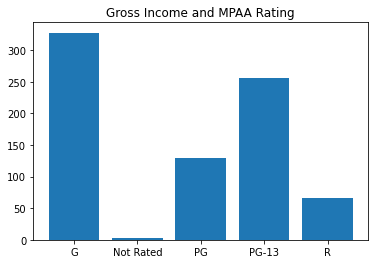

In [33]:
# Correlation between MPAA rating and gross income

plt.bar(age_flat["Motion picture rating (MPAA)"], age_flat["Gross [millions]"])
plt.title("Gross Income and MPAA Rating")

Text(0.5, 1.0, 'Metascore and MPAA Rating')

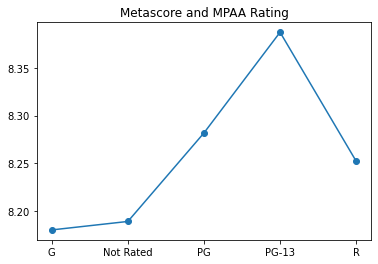

In [34]:
# Correlation between critics rating variation by MPAA rating

plt.plot(age_flat["Motion picture rating (MPAA)"], age_flat["Critics rating"], linestyle="-", marker="o")
plt.title("Metascore and MPAA Rating")